In [35]:
# Import packages.
import numpy as np
import matplotlib.pyplot as plt
import qctrlvisualizer
import boulderopal as bo

# Apply Q-CTRL style to plots created in pyplot.
plt.style.use(qctrlvisualizer.get_qctrl_style())

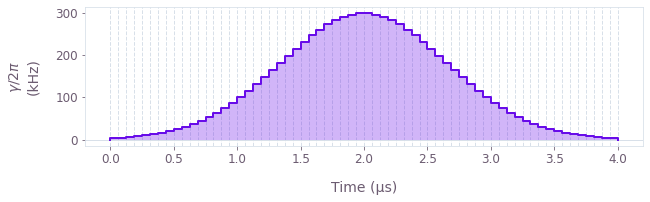

In [36]:
# Total gate duration.
gate_duration = 4e-6  # s
sigma = gate_duration / 6

times, dt = np.linspace(0, gate_duration, 64, retstep=True)
drive_values = np.exp(-((times - gate_duration / 2) ** 2) / 2 / sigma**2)
drive_values = np.pi * drive_values / np.sum(drive_values * dt)

# Visualize drive pulse.
qctrlvisualizer.plot_controls(
    {
        r"$\gamma$": {
            "values": drive_values,
            "durations": np.repeat(gate_duration / 64, 64),
        }
    }
)

In [37]:
# Physical properties of the transmon.
transmon_dimension = 4
alpha = 2 * np.pi * 0.45e6  # rad.Hz

# Create transmon object.
transmon = bo.superconducting.Transmon(
    dimension=transmon_dimension, anharmonicity=alpha, drive=drive_values
)

In [38]:
# Initial state.
transmon_ground_state = np.zeros(transmon_dimension)
transmon_ground_state[0] = 1

In [39]:
simulation_result = bo.superconducting.simulate(
    transmons=[transmon],
    cavities=[],
    interactions=[],
    gate_duration=gate_duration,
    initial_state=transmon_ground_state,
)

Your task (action_id="1915006") is queued.
Your task (action_id="1915006") has completed.


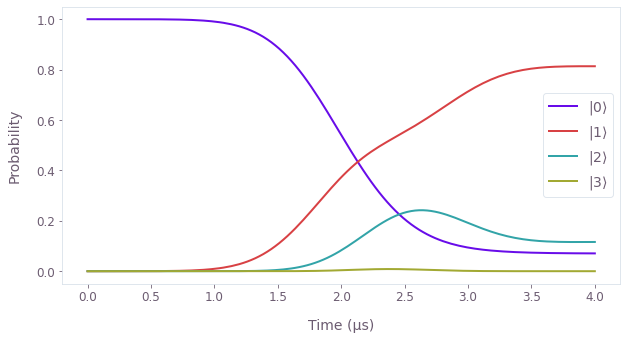

In [40]:
states = np.reshape(
    simulation_result["output"]["state_evolution"]["value"], [-1, transmon_dimension]
)

populations = np.abs(states) ** 2

qctrlvisualizer.plot_population_dynamics(
    simulation_result["output"]["sample_times"]["value"],
    {rf"$|{idx}\rangle$": populations[:, idx] for idx in range(transmon_dimension)},
)

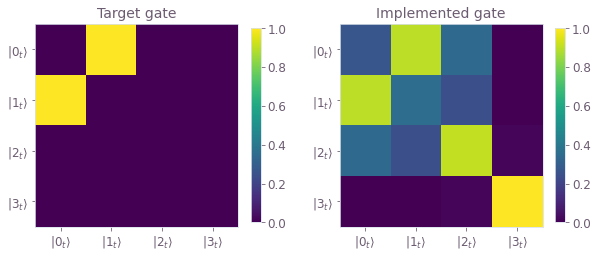

In [45]:
# Define the target gate and retrieve the implemented unitary.
target_operation = np.zeros([transmon_dimension, transmon_dimension])
target_operation[[0, 1], [1, 0]] = 1.0
# Different target operation - 
# target_operation[[0, 0], [1, 1]] = 1.0
implemented_operation = simulation_result["output"]["unitaries"]["value"][-1]


# Plot operators.
def plot_operator(ax, operator, title):
    image = ax.imshow(np.abs(operator), vmin=0, vmax=1)
    plt.colorbar(image, ax=ax, shrink=0.7)
    tick_labels = [rf"$|{t}_t\rangle$" for t in range(transmon_dimension)]
    ax.set_xticks(range(transmon_dimension), tick_labels)
    ax.set_yticks(range(transmon_dimension), tick_labels)
    ax.set_title(title)


fig, axs = plt.subplots(1, 2)
plot_operator(axs[0], target_operation, "Target gate")
plot_operator(axs[1], implemented_operation, "Implemented gate")